In [ ]:
import cv2
import numpy as np
from numba import cuda
import numba
import math
from time import time
import PIL
from PIL import Image

In [ ]:
!wget "https://cameralabs.org/aeonmedia/zenfoto/1725/12729/kabuki-i-koljosa-2013-fotograf-devid-drebin_large.jpg"

--2020-12-04 16:00:26--  https://cameralabs.org/aeonmedia/zenfoto/1725/12729/kabuki-i-koljosa-2013-fotograf-devid-drebin_large.jpg
Resolving cameralabs.org (cameralabs.org)... 31.31.201.130
Connecting to cameralabs.org (cameralabs.org)|31.31.201.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343971 (336K) [image/jpeg]
Saving to: ‘kabuki-i-koljosa-2013-fotograf-devid-drebin_large.jpg.1’

kabuki-i-koljosa-20 100%[===================>] 335.91K  2.14MB/s    in 0.2s    

2020-12-04 16:00:26 (2.14 MB/s) - ‘kabuki-i-koljosa-2013-fotograf-devid-drebin_large.jpg.1’ saved [343971/343971]



In [ ]:
def get_param(img, koaf):
  new_shape = (int(img.shape[0]*koaf), int(img.shape[1]*koaf))
  res = np.empty(new_shape, dtype = np.uint8)
  row_sc = float(float(img.shape[0]) / float(res.shape[0]))
  col_sc = float(float(img.shape[1]) / float(res.shape[1]))
  img_copy = img.copy()
  img_copy = np.vstack([img_copy, img_copy[img_copy.shape[0]-1, : ]])
  img_copy = np.hstack([img_copy, (img_copy[:, img_copy.shape[1]-1]).reshape(-1,1)])
  return res, row_sc, col_sc, img_copy

In [ ]:
def cpu_bilinear_interpolate(im, pix, x, y, row_sc, col_sc):
  X_int = int(x*row_sc)
  Y_int = int(y*col_sc)
  X_float = x*row_sc - X_int
  Y_float = y*col_sc - Y_int
  X_int_inc = min(X_int+1, im.shape[1]-1)
  Y_int_inc = min(Y_int+1, im.shape[0]-1)

  bl = pix[Y_int, X_int]
  br = pix[Y_int, X_int_inc]
  tl = pix[Y_int_inc, X_int]
  tr = pix[Y_int_inc, X_int_inc]

  b = X_float*br + (1. - X_float)*bl
  t = X_float*tr + (1. - X_float)*tl
  result = int(Y_float*t + (1. - Y_float)*b + 0.5)
  return result

In [ ]:
def prepare_and_exec_cpu(img, koaf):
  res, row_sc, col_sc, img_copy = get_param(img, koaf)
  start = time()
  for r in range(res.shape[0]):
    for c in range(res.shape[1]):
      old_r = r * row_sc 
      old_c = c * col_sc
      res[r, c] = cpu_bilinear_interpolate(img, img_copy, c, r, row_sc, col_sc)
  return res, time()-start 


In [ ]:
@cuda.jit
def gpu_bilinear_interpolation(res_global, copy_global, row_sc_global, col_sc_global, m, n):
  r_, c_ = cuda.grid(2)
  r_int = int(r_* row_sc_global[0])
  c_int = int(c_* col_sc_global[0])
  r_float = r_*row_sc_global[0] - r_int
  c_float = c_*col_sc_global[0] - c_int
  if int(r_int+1.)<int(m[0]-1.):
    r_int_inc=int(r_int+1.)
  else:
    r_int_inc=int(m[0]-1.)
  
  if int(c_int+1.)<int(n[0]-1.):
    c_int_inc=int(c_int+1.)
  else:
    c_int_inc=int(n[0]-1.)
    
  bl = copy_global[c_int, r_int]
  br = copy_global[c_int, r_int_inc]
  tl = copy_global[c_int_inc, r_int]
  tr = copy_global[c_int_inc, r_int_inc]

  b = r_float*br + (1. - r_float)*bl
  t = r_float*tr + (1. - r_float)*tl
  res_global[c_,r_] = int(c_float*t + (1. - c_float)*b + 0.5)

In [ ]:
def prepare_and_exec_gpu(img, koaf):
  res, row_sc, col_sc, img_copy = get_param(img, koaf)
  tread_number_block = 32

  row_sc_global = cuda.to_device(row_sc)
  col_sc_global = cuda.to_device(col_sc)
  img_copy_global = cuda.to_device(img_copy)
  res_global = cuda.to_device(res)
  m_global = cuda.to_device(img.shape[1])
  n_global = cuda.to_device(img.shape[0])
  
  threadsperblock = (tread_number_block, tread_number_block)
  blockspergrid_x = int(math.ceil(res_global.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(res_global.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  start = time()
  gpu_bilinear_interpolation[blockspergrid, threadsperblock](res_global, img_copy_global, row_sc_global, col_sc_global, m_global, n_global)
  return res_global.copy_to_host(), time()-start 

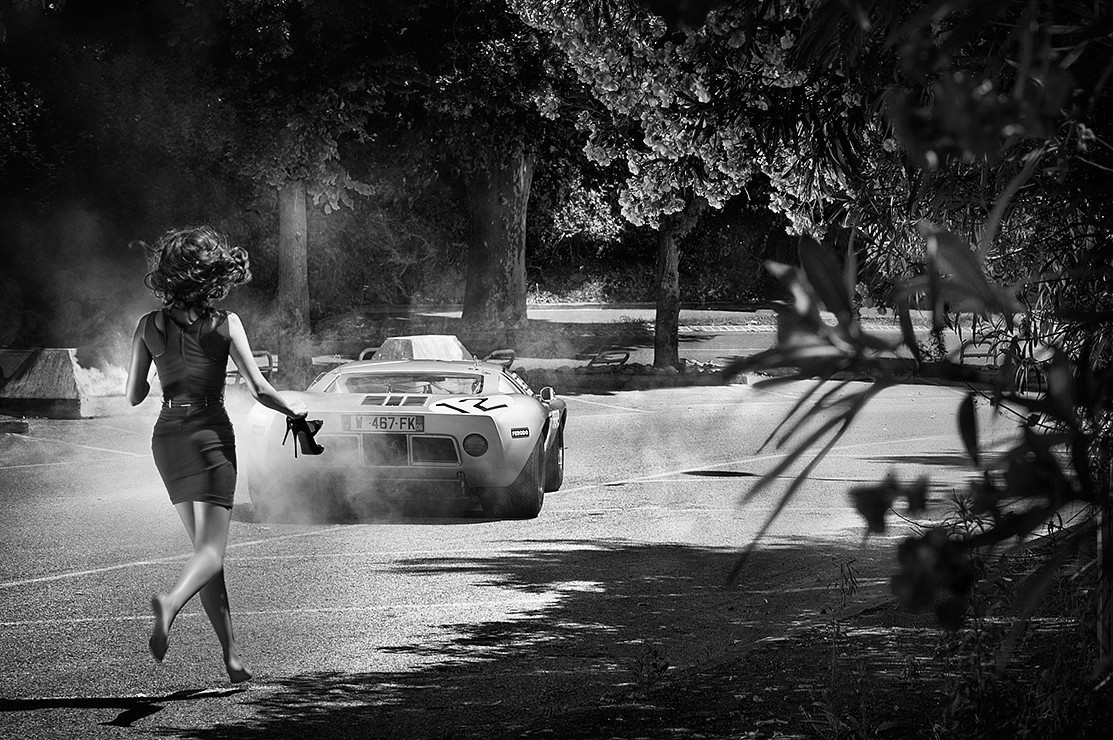

cpu_time: 40.18815779685974


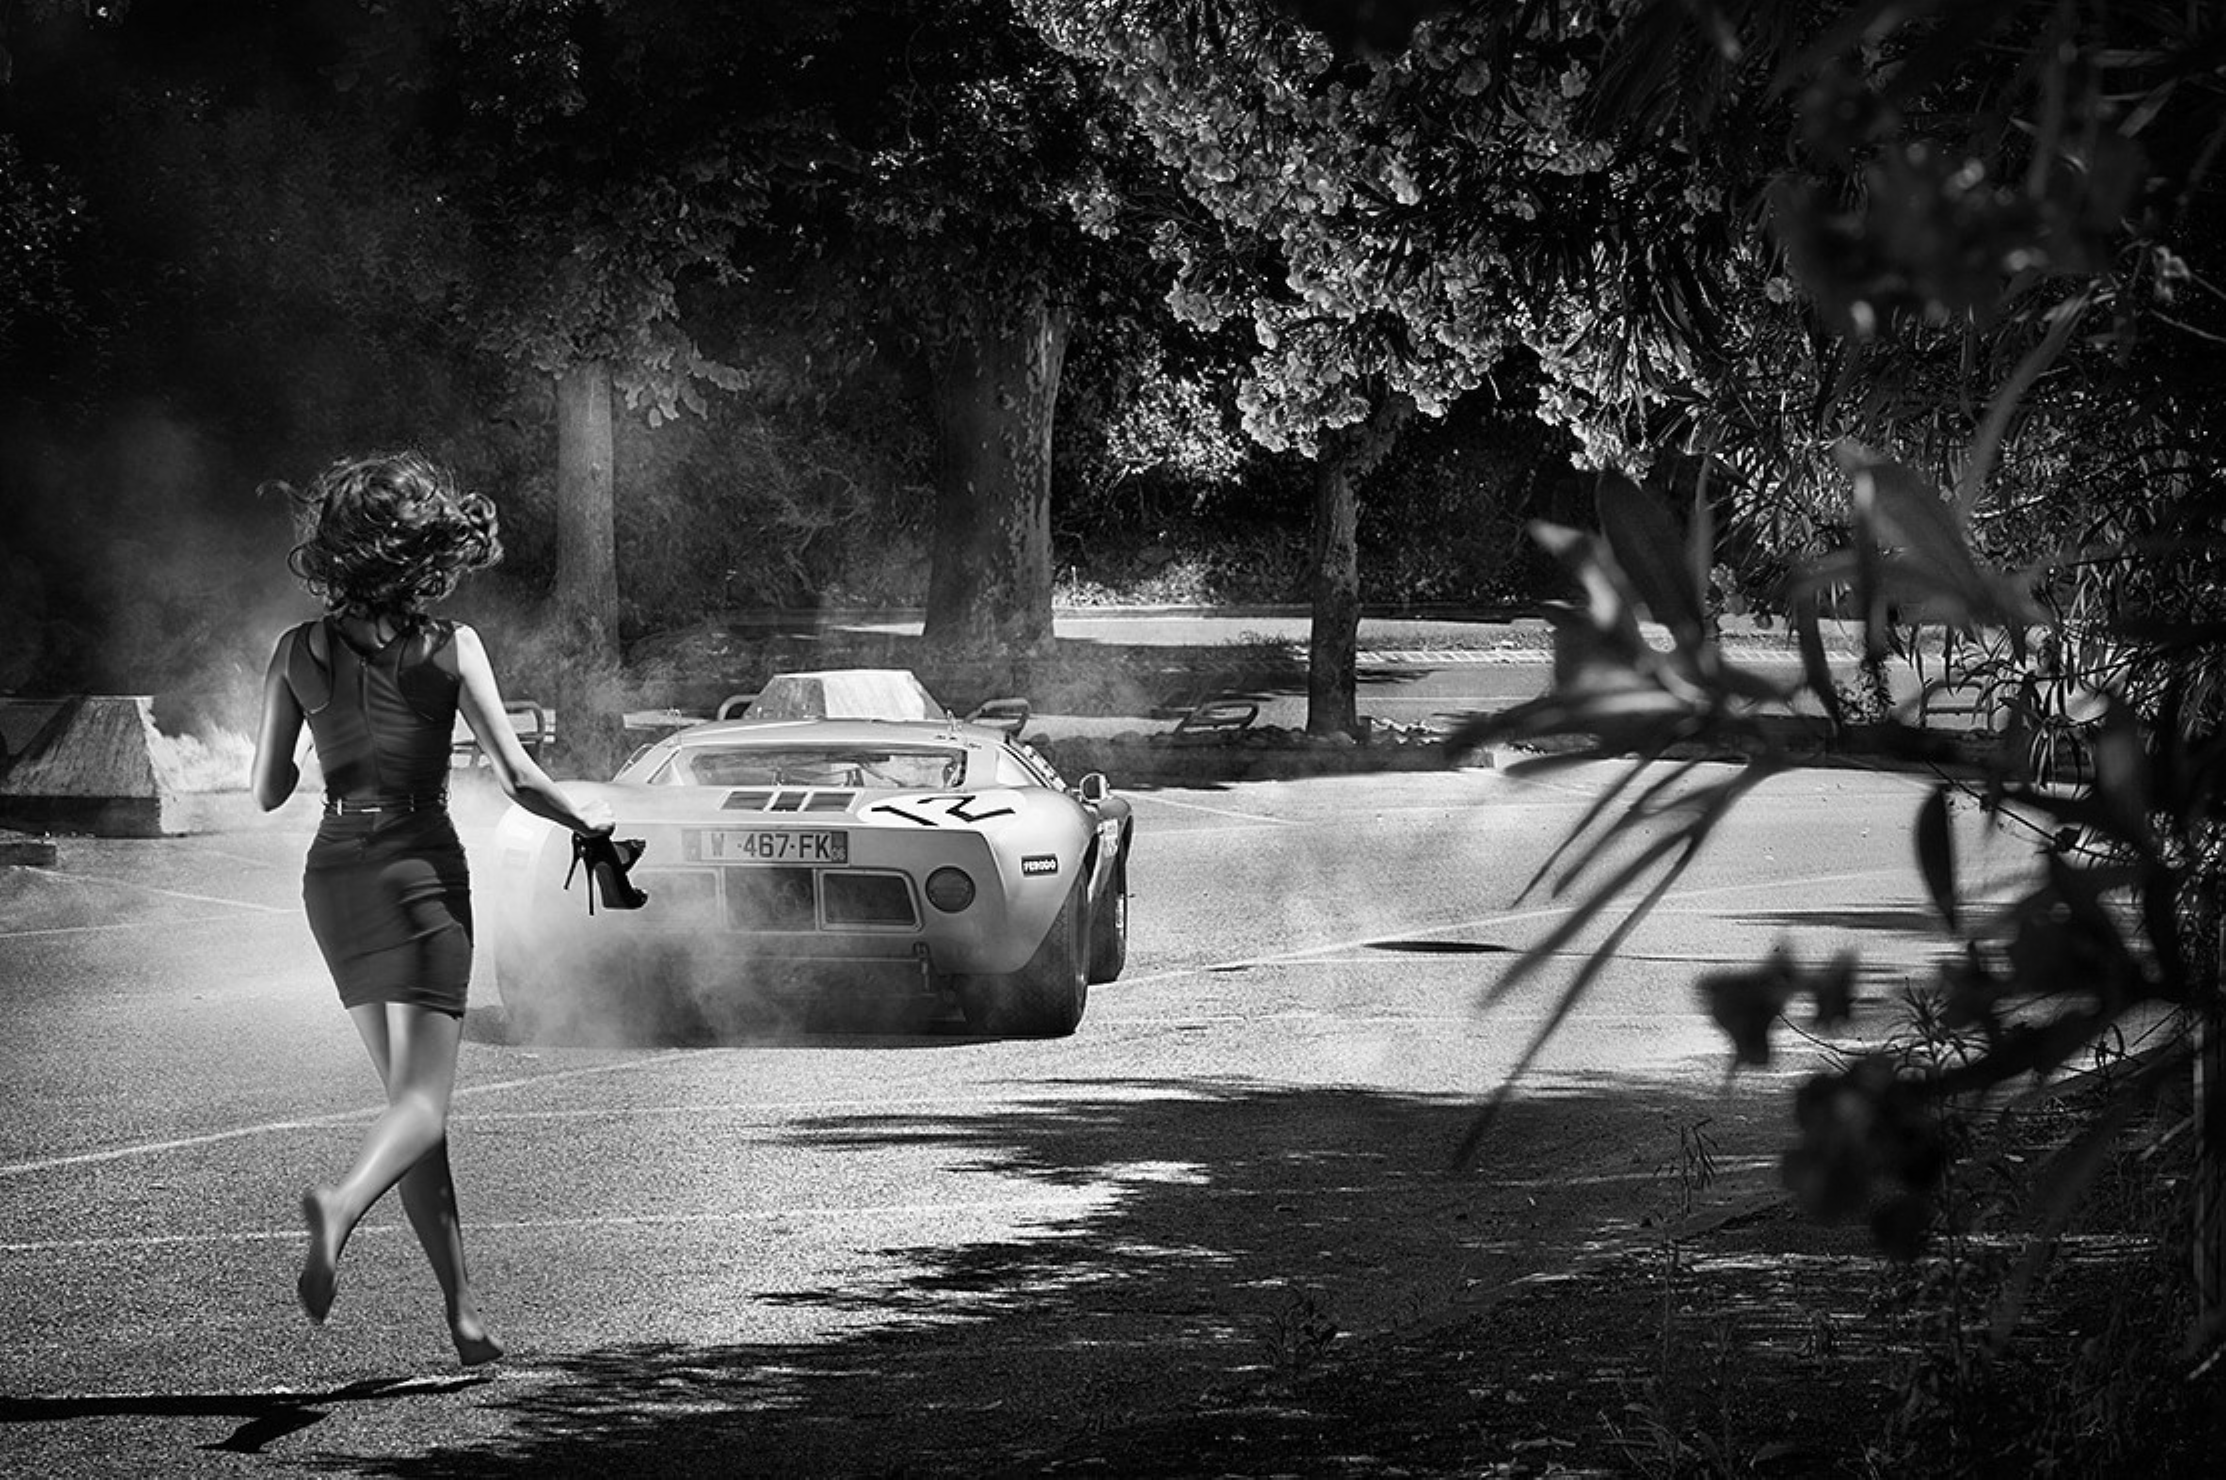

CudaAPIError: ignored

In [ ]:
def experiment(img_name, need_draw, koaf):
  im=(Image.open(img_name)).convert('L')
  if need_draw==True:
    display(im)
  img = np.array(im)
  
  img2, cpu_time = prepare_and_exec_cpu(img, koaf)
  
  print('cpu_time:', cpu_time)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))
  
  img2, gpu_time = prepare_and_exec_gpu(img, koaf)
  print('gpu_time:', gpu_time)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))
  return cpu_time/gpu_time

a = experiment('kabuki-i-koljosa-2013-fotograf-devid-drebin_large.jpg', True, 2)
print('ускорение:', a)
